In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/MyDrive/Breast_US.zip

Archive:  gdrive/MyDrive/Breast_US.zip
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104)_mask.png  
  inflating: Dataset_BUSI

**Import Libraries**

In [3]:
import os
import sys
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,UpSampling2D,Add
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, schedules, Adam,Adadelta
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, GlobalMaxPool2D
from keras.models import Model, load_model
from tensorflow.python.keras import losses

In [4]:
from keras.layers import concatenate
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.utils import plot_model

**Load Dataset**

In [5]:
image_height = 256
image_width = 256
dpath= "/content/Dataset_BUSI_with_GT/"
classes = ['benign', 'malignant', 'normal']

In [6]:
data = {'image' : [],
        'mask' : []}

In [7]:
os.listdir(dpath)

['benign', 'malignant', 'normal']

In [8]:
def load_data(path, data_obj, class_name):
    img_names_list = os.listdir(path+class_name)
    image_names = []
    mask_names = []
    names_truncated = []

    for i in range(len(img_names_list)):
        names_truncated.append(img_names_list[i].split(')')[0])

    names_truncated = list(set(names_truncated))

    for i in range(len(names_truncated)):
        image_names.append(names_truncated[i]+').png')
        mask_names.append(names_truncated[i]+')_mask.png')

    data_obj = preprocess_data(image_names, mask_names, image_width, image_height, path, class_name, data_obj)


    return data_obj

**Data Preprocessing**

In [9]:
def preprocess_data(image_names, mask_names, img_width, img_height, dpath, dclass, data_obj):
    for index in range (len(image_names)):
        image_path = dpath+'/'+dclass+'/'+ image_names[index]
        mask_path = dpath+'/'+dclass+'/'+ mask_names[index]

        x = cv2.imread(image_path, cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = np.round(cv2.resize(x, (image_height, image_width)))
        x.dtype = np.uint8
        y = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        y = cv2.resize(y, (image_height, image_width))

        x= x/255.0
        y= y/255.0
        data_obj['image'].append(x)
        data_obj['mask'].append(y)

    return data_obj

In [10]:
data = load_data(dpath, data, classes[0])
ln = len(data['image'])
print("Number of benign tumor images", ln)
data = load_data(dpath, data, classes[1])
print("Number of malignant tumor images", len(data['image'])-ln)
print("Total images for segmentation", len(data['image']))

Number of benign tumor images 437
Number of malignant tumor images 210
Total images for segmentation 647


In [11]:
type(data['image'])

list

In [12]:
data['mask'][0].shape

(256, 256)

**Visualization**

In [13]:
def visualize_example(data, index = None):
    if index is None:
        index = random.randint(0, len(data['image']))
    X = data['image']
    y = data['mask']
    has_mask = y[index].max() > 0

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(X[index])
    if has_mask:
        ax[0].contour(y[index].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')

    ax[1].imshow(y[index].squeeze())
    ax[1].set_title('Mask')

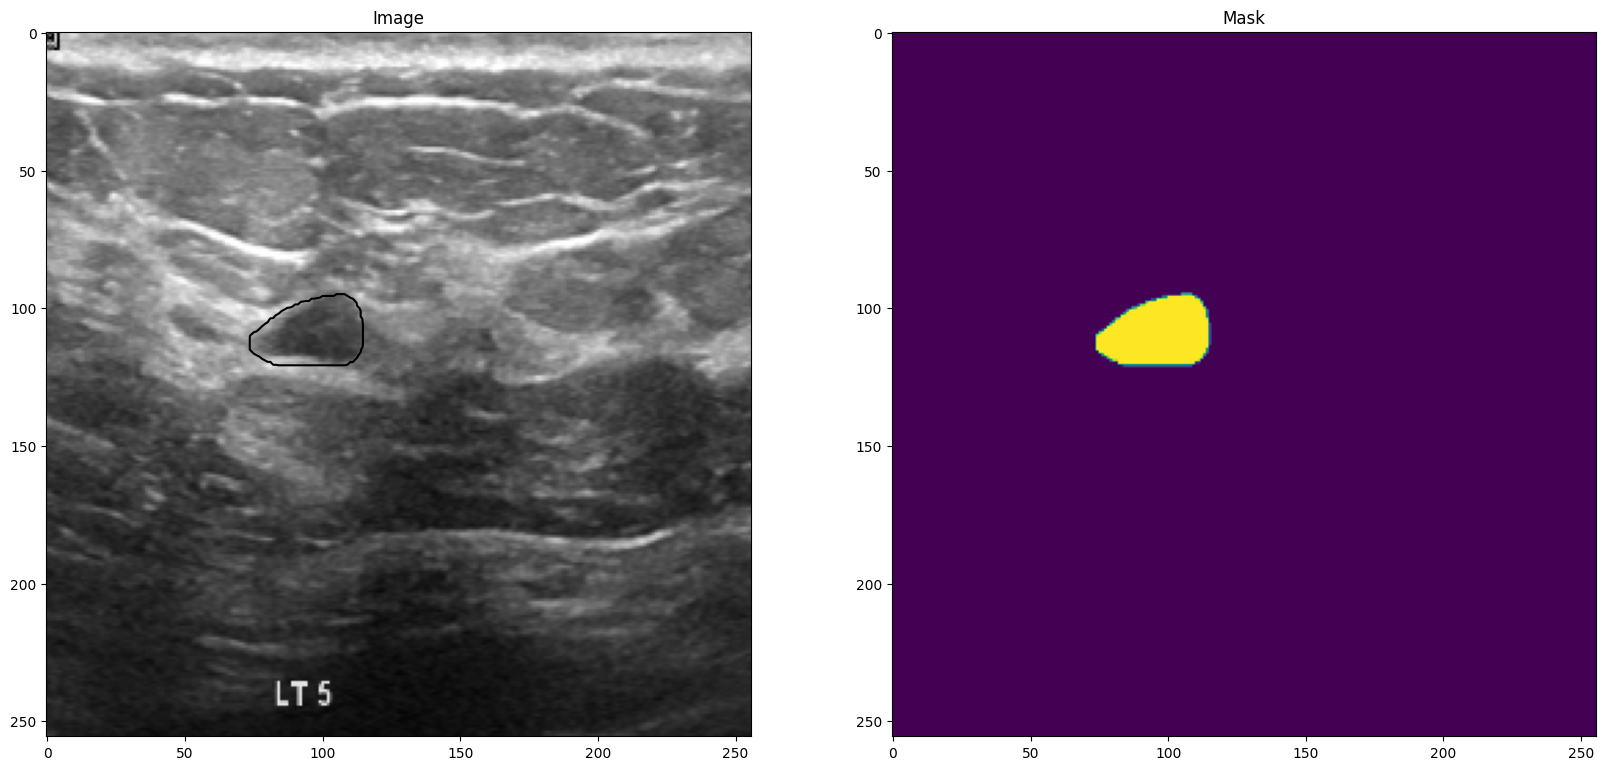

In [14]:
visualize_example(data)

In [15]:
data['image'] = np.array(data['image'])
data['image'].shape

(647, 256, 256, 3)

In [16]:
data['mask'] = np.array(data['mask'])
data['mask'] =  np.expand_dims(data['mask'], -1)
data['mask'].shape

(647, 256, 256, 1)

**Train-Test Split**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data['image'], data['mask'], test_size=0.1, random_state=42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

582 582 65 65


In [18]:
X_train.shape

(582, 256, 256, 3)

In [19]:
tf.keras.backend.clear_session()

**Loss Function**

In [20]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [21]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [22]:
def tot_loss(y_true,y_pred):
  l1=losses.binary_crossentropy(y_true, y_pred)
  l2= dice_loss(y_true,y_pred)
  l=l1+l2
  # l=l2
  return l

**Models**

In [23]:
# def bn_act(x, act=True):
#   #'batch normalization layer with an optinal activation layer'
#   x = tf.keras.layers.BatchNormalization()(x)
#   if act == True:
#     x = tf.keras.layers.Activation('relu')(x)
#   return x

In [24]:
# def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
#     # 'convolutional layer which always uses the batch normalization layer'

#     conv = bn_act(x)
#     conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
#     return conv

In [25]:
# def stem(x, filters, kernel_size=3, padding='same', strides=1):
#     conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
#     conv = conv_block(conv, filters, kernel_size, padding, strides)
#     shortcut = Conv2D(filters, kernel_size=1, padding=padding, strides=strides)(x)
#     shortcut = bn_act(shortcut, act=False)
#     output = Add()([conv, shortcut])
#     return output

In [26]:
# def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
#     res = conv_block(x, filters, kernel_size, padding, strides)
#     res = conv_block(res, filters, kernel_size, padding, 1)
#     shortcut = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
#     shortcut = bn_act(shortcut, act=False)
#     output = Add()([shortcut, res])
#     return output

In [27]:
# def upsample_concat_block(x, xskip):
#   u = UpSampling2D((2,2))(x)
#   c = concatenate([u, xskip],)
#   return c

In [28]:
# *************** ResUNet *********************
# def ResUNet(img_h, img_w):
#     f = [16, 32, 64, 128, 256]
#     inputs = Input((img_h, img_w, 3))

#     ## Encoder
#     e0 = inputs
#     e1 = stem(e0, f[0])
#     p1= Dropout(0.4)(e1)


#     e2 = residual_block(p1, f[1], strides=2)
#     p2= Dropout(0.4)(e2)


#     e3 = residual_block(p2, f[2], strides=2)
#     p3= Dropout(0.3)(e3)


#     e4 = residual_block(p3, f[3], strides=2)
#     p4= Dropout(0.3)(e4)

#     e5 = residual_block(p4, f[4], strides=1)

#     ## Bridge
#     # b0 = conv_block(e4, f[3], strides=1)
#     # b1 = conv_block(b0, f[3], strides=1)
#     p5 = MaxPooling2D((2, 2))(e5)
#     ## Decoder
#     u1 = upsample_concat_block(p5, e4)
#     d1 = residual_block(u1, f[3])
#     p6=Dropout(0.4)(d1)


#     u2 = upsample_concat_block(p6, e3)
#     d2 = residual_block(u2, f[2])
#     p7= Dropout(0.4)(d2)

#     u3 = upsample_concat_block(p7, e2)
#     d3 = residual_block(u3, f[1])
#     p8=Dropout(0.3)(d3)


#     u4 = upsample_concat_block(d3, e1)
#     d4 = residual_block(u4, f[0])
#     p9= Dropout(0.3)(d4)

#     outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(p9)
#     model = tf.keras.models.Model(inputs, outputs)
#     return model

In [23]:
# #****************** U Net Architecture****************************
# def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
#     # first layer
#     x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
#               kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
#     if batchnorm:
#         x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     # second layer
#     x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
#               kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
#     if batchnorm:
#         x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     return x
# def get_unet(input_img, n_filters = 16, dropout = 0.3, batchnorm = True):
#     # Contracting Path
#     c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
#     p1 = MaxPooling2D((2, 2))(c1)
#     p1 = Dropout(dropout)(p1)

#     c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
#     p2 = MaxPooling2D((2, 2))(c2)
#     p2 = Dropout(dropout)(p2)

#     c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
#     p3 = MaxPooling2D((2, 2))(c3)
#     p3 = Dropout(dropout)(p3)

#     c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
#     p4 = MaxPooling2D((2, 2))(c4)
#     p4 = Dropout(dropout)(p4)

#     c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

#     # Expansive Path
#     u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
#     u6 = concatenate([u6, c4])
#     u6 = Dropout(dropout)(u6)
#     c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

#     u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
#     u7 = concatenate([u7, c3])
#     u7 = Dropout(dropout)(u7)
#     c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

#     u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
#     u8 = concatenate([u8, c2])
#     u8 = Dropout(dropout)(u8)
#     c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

#     u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
#     u9 = concatenate([u9, c1])
#     u9 = Dropout(dropout)(u9)
#     c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

#     outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
#     model = Model(inputs=[input_img], outputs=[outputs])
#     return model

In [ ]:
# ******* Nested UNet*********
# def conv_block(inputs, n_filters, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal'):
#     c = Conv2D(n_filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(inputs)
#     c = BatchNormalization()(c)
#     c = Conv2D(n_filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(c)
#     c = BatchNormalization()(c)
#     return c

# def nested_unet_model(IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
#     # Build the model
#     inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#     s = inputs

#     # Contracting path
#     c1 = conv_block(s, 16)
#     p1 = MaxPooling2D((2, 2))(c1)
#     c2 = conv_block(p1, 32)
#     p2 = MaxPooling2D((2, 2))(c2)
#     c3 = conv_block(p2, 64)
#     p3 = MaxPooling2D((2, 2))(c3)
#     c4 = conv_block(p3, 128)
#     p4 = MaxPooling2D(pool_size=(2, 2))(c4)
#     c5 = conv_block(p4, 256)

#     # Expansive path
#     u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
#     u6 = concatenate([u6, c4])
#     c6 = conv_block(u6, 128)
#     u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
#     u7 = concatenate([u7, c3])
#     c7 = conv_block(u7, 64)
#     u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
#     u8 = concatenate([u8, c2])
#     c8 = conv_block(u8, 32)
#     u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
#     u9 = concatenate([u9, c1], axis=3)
#     c9 = conv_block(u9, 16)

#     outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

#     model = Model(inputs=[inputs], outputs=[outputs])
#     return model

In [23]:
# def attention_block(x, shortcut, filters, kernel_size=(3, 3), padding="same"):
#     g1 = Conv2D(filters, kernel_size, padding=padding)(x)
#     g1 = BatchNormalization()(g1)
#     x1 = Conv2D(filters, kernel_size, padding=padding)(shortcut)
#     x1 = BatchNormalization()(x1)
#     f = Activation('relu')(g1 + x1)
#     g2 = Conv2D(filters, kernel_size, padding=padding)(f)
#     g2 = BatchNormalization()(g2)
#     x2 = Conv2D(filters, kernel_size, padding=padding)(f)
#     x2 = BatchNormalization()(x2)
#     h = Activation('sigmoid')(g2 + x2)
#     return f * h + f

# def attention_unetplusplus_model(IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
#     # Build the model
#     inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#     #s = Lambda(lambda x: x / 255)(inputs)   # No need for this if we normalize our inputs beforehand
#     s = inputs

#     # Contraction path
#     c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
#     c1 = Dropout(0.1)(c1)
#     c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
#     p1 = MaxPooling2D((2, 2))(c1)

#     c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
#     c2 = Dropout(0.1)(c2)
#     c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
#     p2 = MaxPooling2D((2, 2))(c2)

#     c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
#     c3 = Dropout(0.2)(c3)
#     c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
#     p3 = MaxPooling2D((2, 2))(c3)

#     c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
#     c4 = Dropout(0.2)(c4)
#     c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
#     p4 = MaxPooling2D(pool_size=(2, 2))(c4)

#     c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
#     c5 = Dropout(0.3)(c5)
#     c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#         # Expansive path
#     u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
#     u6 = concatenate([u6, c4])
#     u6 = Dropout(0.2)(u6)
#     u6 = attention_block(u6, c4, 128)
#     c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
#     c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

#     u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
#     u7 = concatenate([u7, c3])
#     u7 = Dropout(0.2)(u7)
#     u7 = attention_block(u7, c3, 64)
#     c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
#     c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

#     u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
#     u8 = concatenate([u8, c2])
#     u8 = Dropout(0.1)(u8)
#     u8 = attention_block(u8, c2, 32)
#     c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
#     c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

#     u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
#     u9 = concatenate([u9, c1])
#     u9 = Dropout(0.1)(u9)
#     u9 = attention_block(u9, c1, 16)
#     c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
#     c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

#     outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

#     model = Model(inputs=[inputs], outputs=[outputs])
#     return model

In [ ]:
# def conv_block(inputs, n_filters, kernel_size=3, batchnorm=False, activation='relu'):
#     x = Conv2D(n_filters, kernel_size, padding='same')(inputs)
#     if batchnorm:
#         x = BatchNormalization()(x)
#     x = Activation(activation)(x)
#     x = Conv2D(n_filters, kernel_size, padding='same')(x)
#     if batchnorm:
#         x = BatchNormalization()(x)
#     x = Activation(activation)(x)
#     return x

# def up_conv_block(inputs, n_filters, kernel_size=2, batchnorm=False, activation='relu'):
#     x = Conv2DTranspose(n_filters, kernel_size, strides=(2, 2), padding='same')(inputs)
#     if batchnorm:
#         x = BatchNormalization()(x)
#     x = Activation(activation)(x)
#     return x

# def unet_pp3_model(IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
#     # Build the model
#     inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#     # Level 1
#     c1 = conv_block(inputs, 16, batchnorm=True)
#     p1 = MaxPooling2D((2, 2))(c1)

#     # Level 2
#     c2 = conv_block(p1, 32, batchnorm=True)
#     p2 = MaxPooling2D((2, 2))(c2)

#     # Level 3
#     c3 = conv_block(p2, 64, batchnorm=True)
#     p3 = MaxPooling2D((2, 2))(c3)

#     # Level 4
#     c4 = conv_block(p3, 128, batchnorm=True)
#     p4 = MaxPooling2D((2, 2))(c4)

#     # Level 5
#     c5 = conv_block(p4, 256, batchnorm=True)

#     # Level 4a
#     u4a = up_conv_block(c5, 128, batchnorm=True)
#     m4a = concatenate([u4a, c4], axis=3)
#     c4a = conv_block(m4a, 128, batchnorm=True)

#     # Level 3a
#     u3a = up_conv_block(c4a, 64, batchnorm=True)
#     m3a = concatenate([u3a, c3], axis=3)
#     c3a = conv_block(m3a, 64, batchnorm=True)

#     # Level 2a
#     u2a = up_conv_block(c3a, 32, batchnorm=True)
#     m2a = concatenate([u2a, c2], axis=3)
#     c2a = conv_block(m2a, 32, batchnorm=True)

#     # Level 1a
#     u1a = up_conv_block(c2a, 16, batchnorm=True)
#     m1a = concatenate([u1a, c1], axis=3)
#     c1a = conv_block(m1a, 16, batchnorm=True)

#     # Output layer
#     outputs = Conv2D(1, (1, 1), activation='sigmoid')(c1a)

#     model = Model(inputs=[inputs], outputs=[outputs])
#     return model

In [31]:
image_height= 256
image_width= 256
# input_layer= Input((image_height, image_width, 3), name='img')
model = ResUNet(image_height,image_width)
# model = get_unet(input_layer, n_filters=16, dropout=0.3, batchnorm=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 16)         0         ['batch_normalization[0][0

**Step 11: Setting up Hyperparameters**

In [32]:
model.compile(optimizer=Adam(),
                  loss= tot_loss,
                  metrics=[dice_loss, dice_coeff, 'accuracy'])

In [33]:
callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1),
    ModelCheckpoint('model-checkpoint.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [34]:
batch_size = 32
epochs = 70

In [ ]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [35]:
tf.debugging.set_log_device_placement(True)

In [36]:
l_train= len(X_train)
u= np.arange(0,l_train)
print(len(u))

582


**Training the Model**

Epoch 1/70
19/19 [==============================] - ETA: 0s - loss: 1.2383 - dice_loss: 0.7832 - dice_coeff: 0.2168 - accuracy: 0.8022
Epoch 1: val_loss improved from inf to 82.25651, saving model to model-checkpoint.h5
19/19 [==============================] - 61s 1s/step - loss: 1.2383 - dice_loss: 0.7832 - dice_coeff: 0.2168 - accuracy: 0.8022 - val_loss: 82.2565 - val_dice_loss: 0.9814 - val_dice_coeff: 0.0186 - val_accuracy: 0.8976 - lr: 0.0010
Epoch 2/70
19/19 [==============================] - ETA: 0s - loss: 0.9333 - dice_loss: 0.6294 - dice_coeff: 0.3706 - accuracy: 0.8950
Epoch 2: val_loss improved from 82.25651 to 7.71781, saving model to model-checkpoint.h5
19/19 [==============================] - 16s 855ms/step - loss: 0.9333 - dice_loss: 0.6294 - dice_coeff: 0.3706 - accuracy: 0.8950 - val_loss: 7.7178 - val_dice_loss: 0.8153 - val_dice_coeff: 0.1847 - val_accuracy: 0.7496 - lr: 0.0010
Epoch 3/70
19/19 [==============================] - ETA: 0s - loss: 0.8642 - dice_loss: 


Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 48: val_loss did not improve from 0.58097
19/19 [==============================] - 14s 726ms/step - loss: 0.2274 - dice_loss: 0.1504 - dice_coeff: 0.8496 - accuracy: 0.9754 - val_loss: 0.5890 - val_dice_loss: 0.3755 - val_dice_coeff: 0.6245 - val_accuracy: 0.9502 - lr: 1.0000e-04
Epoch 1/70
19/19 [==============================] - ETA: 0s - loss: 0.3673 - dice_loss: 0.2126 - dice_coeff: 0.7874 - accuracy: 0.9634
Epoch 1: val_loss improved from 0.58097 to 0.23765, saving model to model-checkpoint.h5
19/19 [==============================] - 17s 897ms/step - loss: 0.3673 - dice_loss: 0.2126 - dice_coeff: 0.7874 - accuracy: 0.9634 - val_loss: 0.2376 - val_dice_loss: 0.1483 - val_dice_coeff: 0.8517 - val_accuracy: 0.9758 - lr: 1.0000e-04
Epoch 2/70
19/19 [==============================] - ETA: 0s - loss: 0.3534 - dice_loss: 0.2173 - dice_coeff: 0.7827 - accuracy: 0.9641
Epoch 2: val_loss did not improve from 0.23765
19/19


Epoch 48: val_loss did not improve from 0.23765
19/19 [==============================] - 14s 724ms/step - loss: 0.1496 - dice_loss: 0.0957 - dice_coeff: 0.9043 - accuracy: 0.9834 - val_loss: 0.3738 - val_dice_loss: 0.2055 - val_dice_coeff: 0.7945 - val_accuracy: 0.9647 - lr: 1.0000e-04
Epoch 1/70
19/19 [==============================] - ETA: 0s - loss: 0.2503 - dice_loss: 0.1552 - dice_coeff: 0.8448 - accuracy: 0.9745
Epoch 1: val_loss improved from 0.23765 to 0.15966, saving model to model-checkpoint.h5
19/19 [==============================] - 17s 900ms/step - loss: 0.2503 - dice_loss: 0.1552 - dice_coeff: 0.8448 - accuracy: 0.9745 - val_loss: 0.1597 - val_dice_loss: 0.1000 - val_dice_coeff: 0.9000 - val_accuracy: 0.9800 - lr: 1.0000e-04
Epoch 2/70
19/19 [==============================] - ETA: 0s - loss: 0.2266 - dice_loss: 0.1433 - dice_coeff: 0.8567 - accuracy: 0.9770
Epoch 2: val_loss did not improve from 0.15966
19/19 [==============================] - 16s 854ms/step - loss: 0.22


Epoch 48: val_loss did not improve from 0.14583
19/19 [==============================] - 14s 713ms/step - loss: 0.1323 - dice_loss: 0.1068 - dice_coeff: 0.8932 - accuracy: 0.9856 - val_loss: 0.2510 - val_dice_loss: 0.1307 - val_dice_coeff: 0.8693 - val_accuracy: 0.9749 - lr: 1.0000e-04


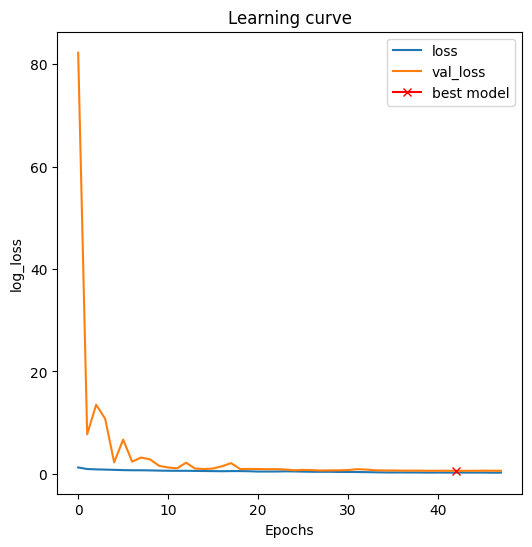

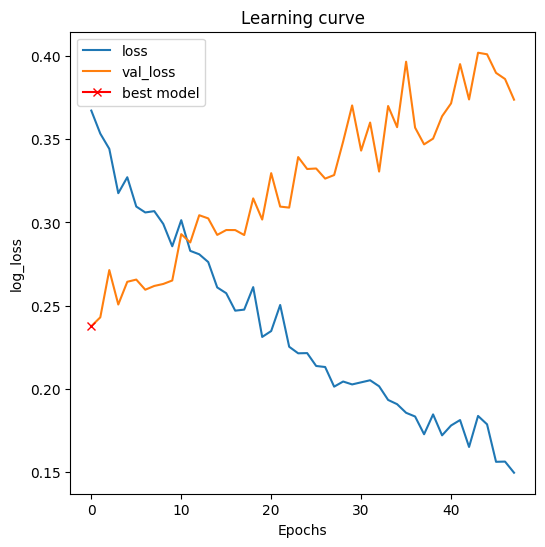

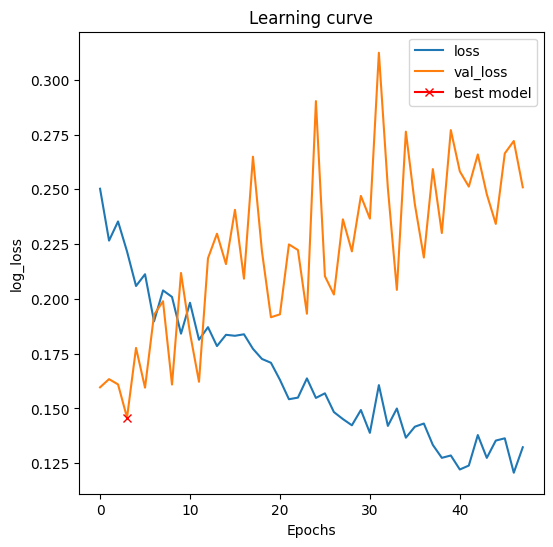

In [37]:
for i in range(3):
  u= np.arange(0,l_train)
  newarr = np.array_split(u, 3)
  x_valid= X_train[newarr[i]]
  y_valid= y_train[newarr[i]]

  newarr= np.delete(newarr, [i],axis=0)
  # x_train= X_train[newarr[0]]
  # yy_train= y_train[newarr[0]]
  x_train= X_train[np.concatenate((newarr[0],newarr[1]),axis=0)]
  yy_train= y_train[np.concatenate((newarr[0],newarr[1]),axis=0)]

  model_history = model.fit(x_train,yy_train,
                    batch_size=batch_size,
                    steps_per_epoch=int(np.ceil(len(X_train) / float(batch_size))),
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=(x_valid, y_valid),
                    verbose = 1)
  plt.figure(figsize=(6, 6))
  plt.title("Learning curve")
  plt.plot(model_history.history["loss"], label="loss")
  plt.plot(model_history.history["val_loss"], label="val_loss")
  plt.plot( np.argmin(model_history.history["val_loss"]), np.min(model_history.history["val_loss"]), marker="x", color="r", label="best model")
  plt.xlabel("Epochs")
  plt.ylabel("log_loss")
  plt.legend();

**Learning Curve Visualization**

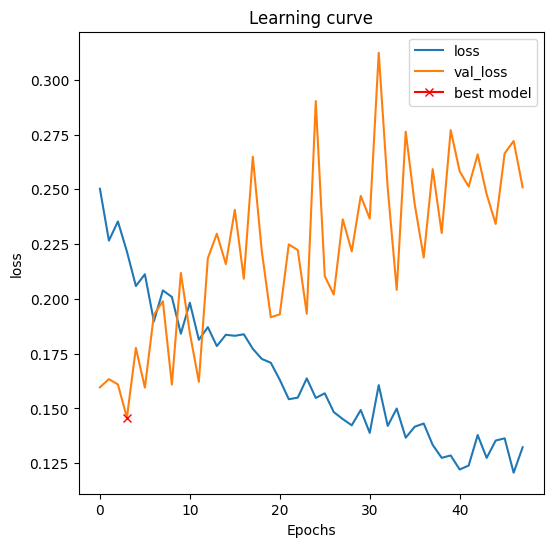

In [38]:
plt.figure(figsize=(6, 6))
plt.title("Learning curve")
plt.plot(model_history.history["loss"], label="loss")
plt.plot(model_history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(model_history.history["val_loss"]), np.min(model_history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

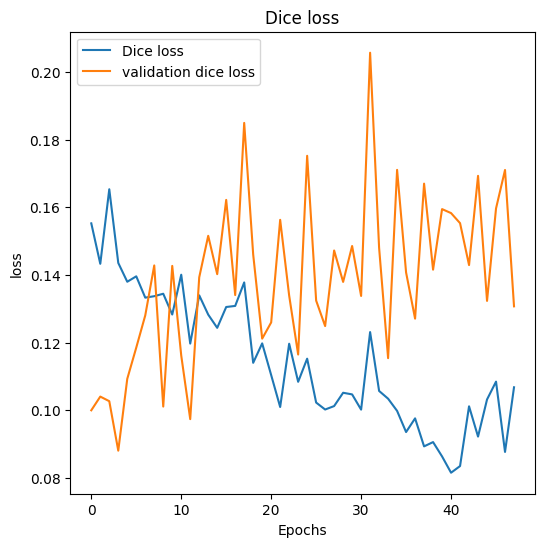

In [39]:
plt.figure(figsize=(6, 6))
plt.title("Dice loss")
plt.plot(model_history.history["dice_loss"], label="Dice loss")
plt.plot(model_history.history["val_dice_loss"], label="validation dice loss")
# plt.plot( np.argmin(model_history.history["val_loss"]), np.min(model_history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

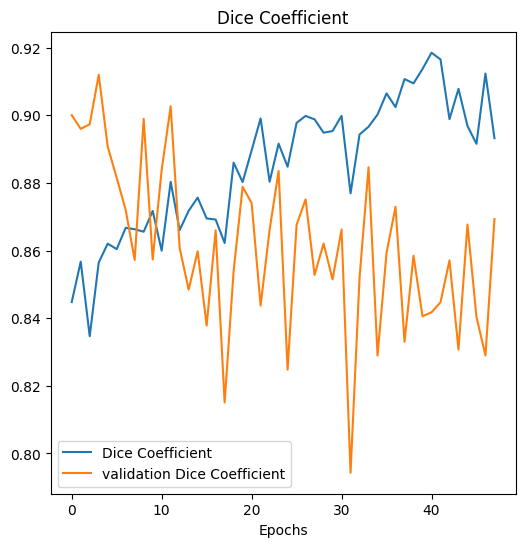

In [40]:
plt.figure(figsize=(6, 6))
plt.title("Dice Coefficient")
plt.plot(model_history.history["dice_coeff"], label="Dice Coefficient")
plt.plot(model_history.history["val_dice_coeff"], label="validation Dice Coefficient")

# plt.plot( np.argmin(model_history.history["val_loss"]), np.min(model_history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
# plt.ylabel("loss")
plt.legend();

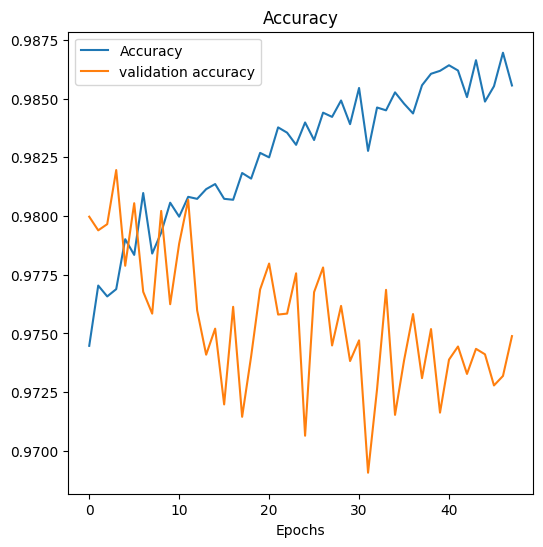

In [41]:
plt.figure(figsize=(6, 6))
plt.title("Accuracy")
plt.plot(model_history.history["accuracy"], label="Accuracy")
plt.plot(model_history.history["val_accuracy"], label="validation accuracy")

# plt.plot( np.argmin(model_history.history["val_loss"]), np.min(model_history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
# plt.ylabel("loss")
plt.legend();

**Evaluating the model on test sets**

In [42]:
model.load_weights('model-checkpoint.h5')
model.evaluate(X_test, y_test, verbose=1)

3/3 [==============================] - 1s 455ms/step - loss: 0.7438 - dice_loss: 0.2865 - dice_coeff: 0.7135 - accuracy: 0.9328


[0.743833601474762,
 0.28654396533966064,
 0.7134559750556946,
 0.9328453540802002]

In [43]:
preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.8).astype(np.uint8)

3/3 [==============================] - 1s 189ms/step


**Manual Testing**

In [44]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    for i in range(len(X)//4):
      has_mask = y[i].max() > 0

      fig, ax = plt.subplots(1, 4, figsize=(20, 10))
      ax[0].imshow(X[i])
      if has_mask:
        ax[0].contour(y[i].squeeze(), colors='k', levels=[0.5])
      ax[0].set_title('Image')

      ax[1].imshow(y[i].squeeze())
      ax[1].set_title('Mask')

      ax[2].imshow(preds[i].squeeze(), vmin=0, vmax=1)
      ax[2].set_title('Mask Predicted')

      ax[3].imshow(binary_preds[i].squeeze(), vmin=0, vmax=1)
      ax[3].set_title('Mask Predicted binary');


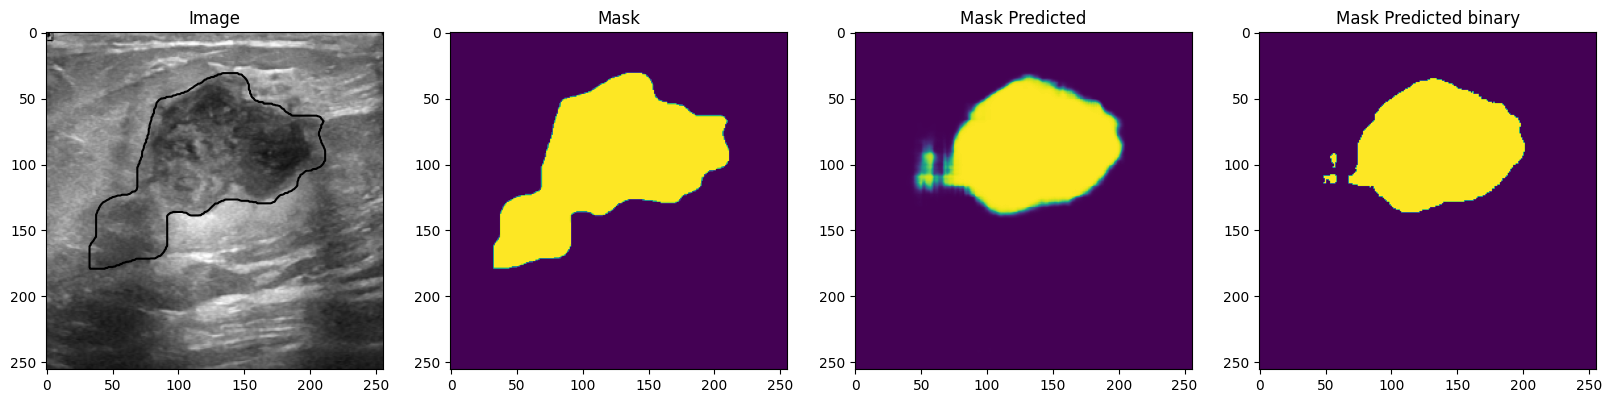

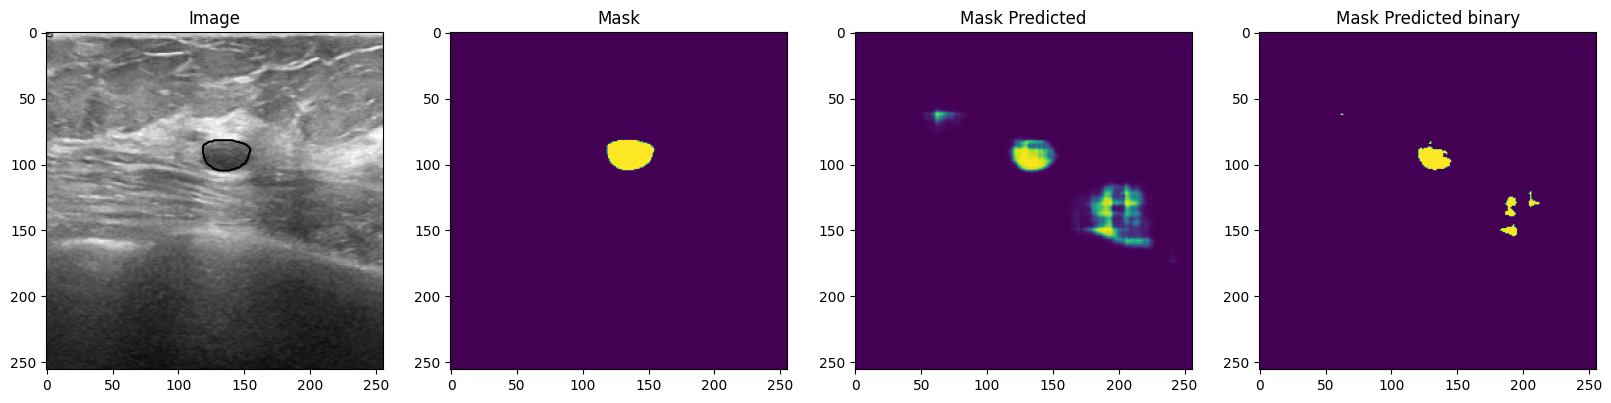

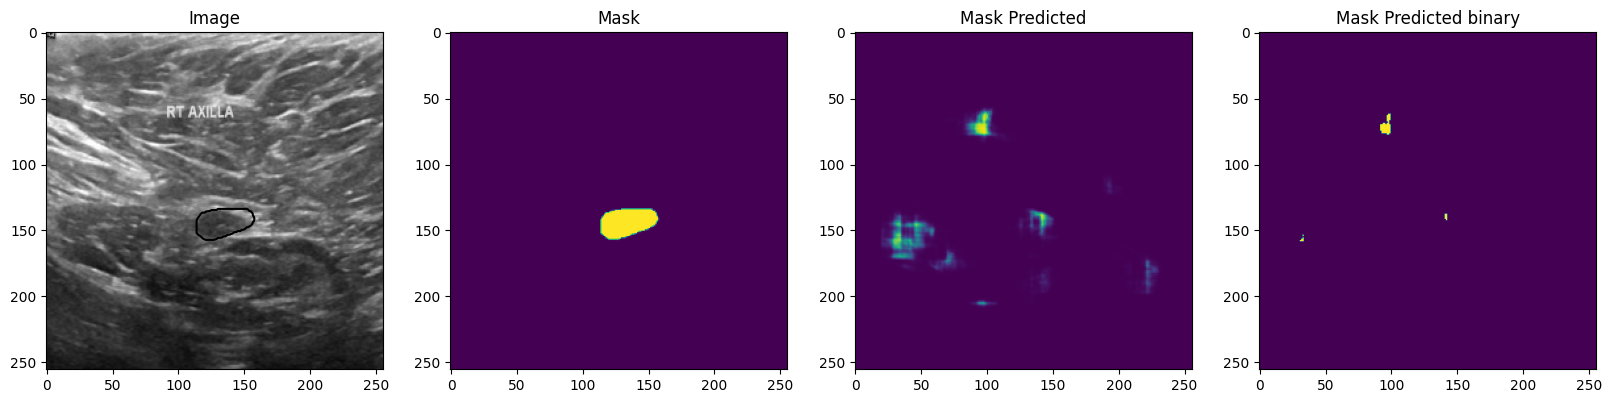

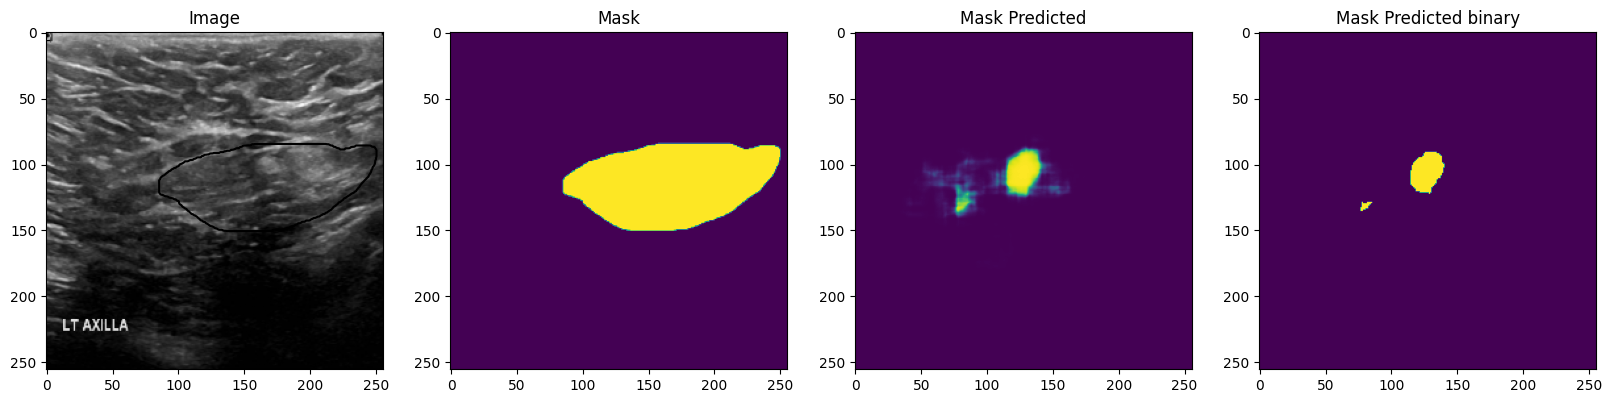

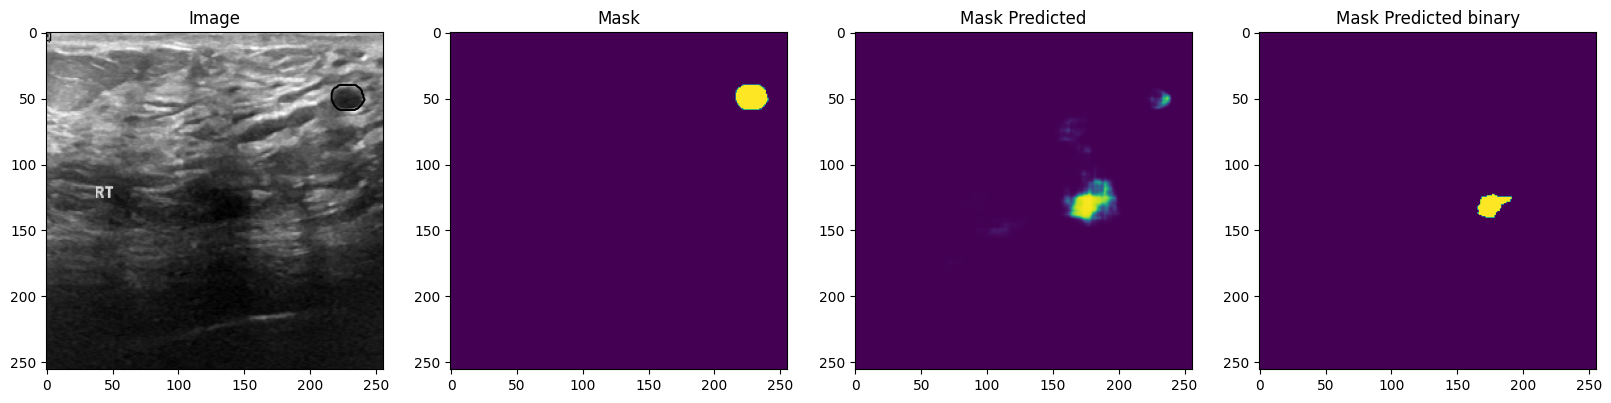

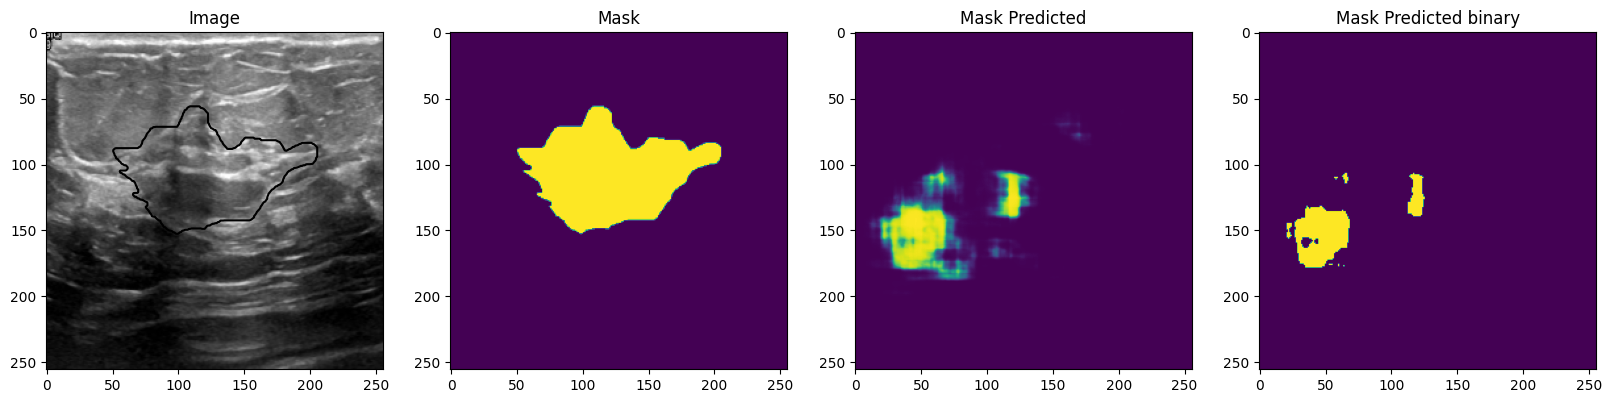

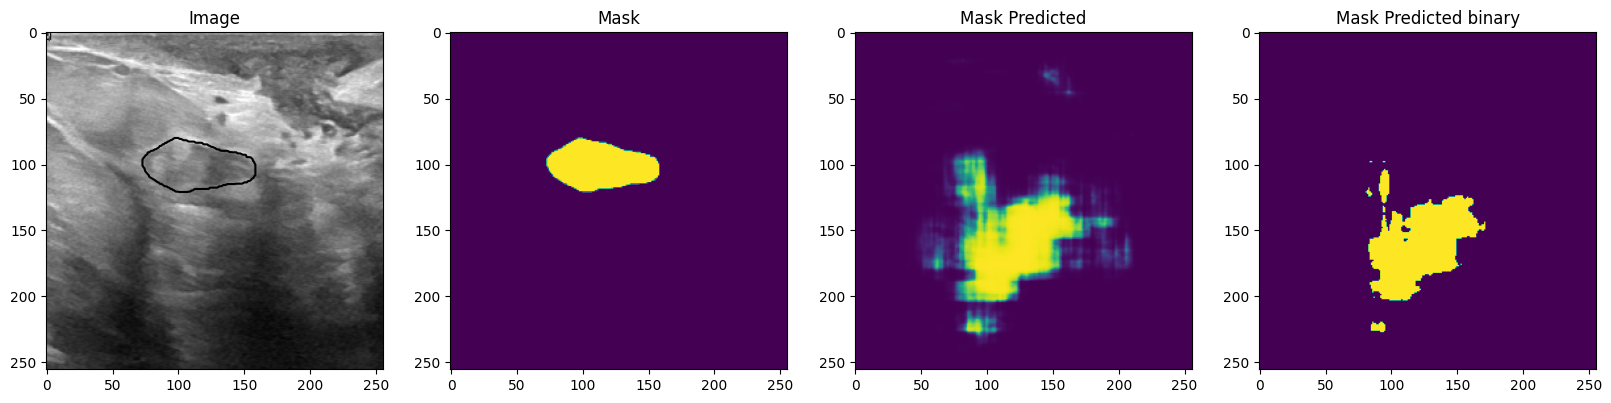

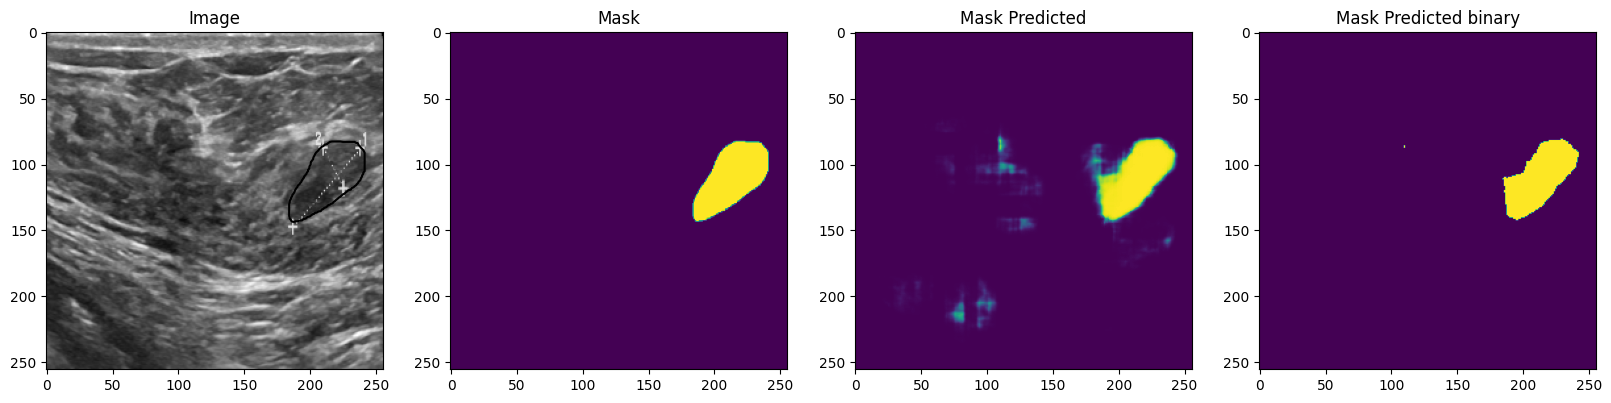

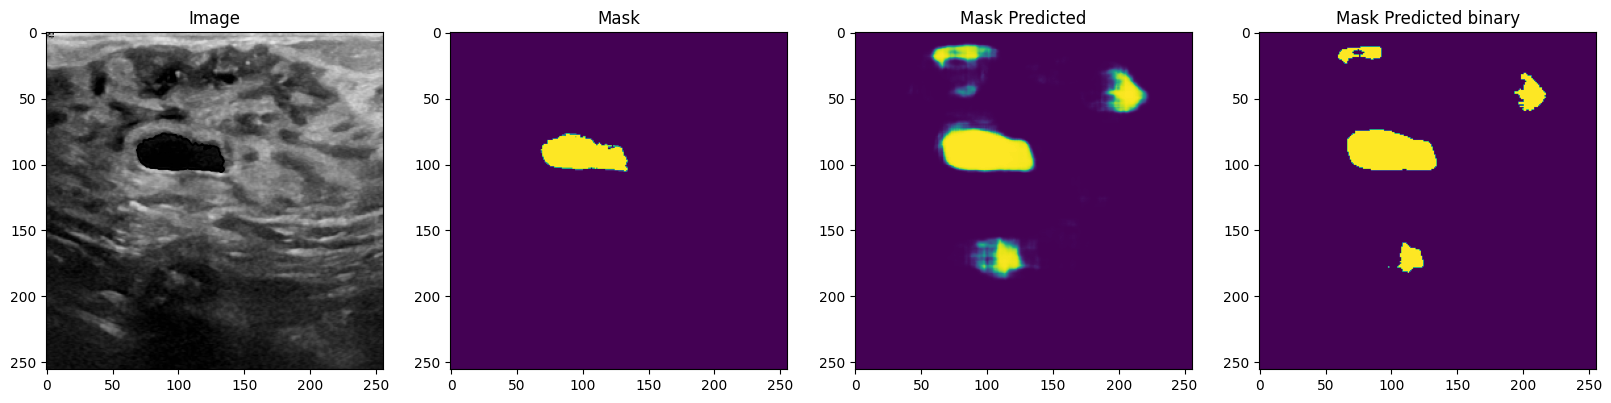

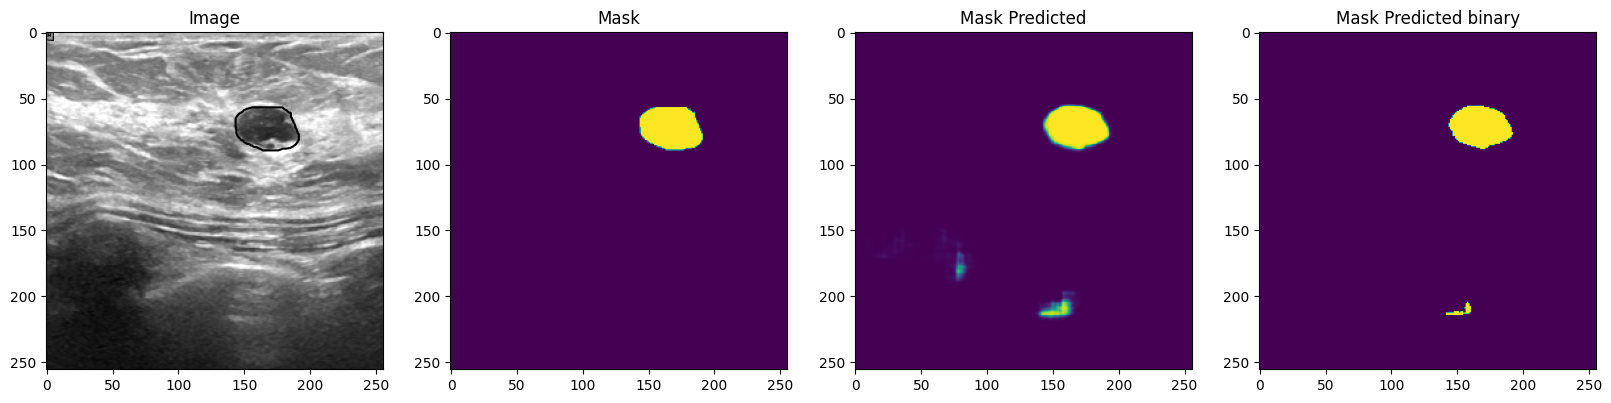

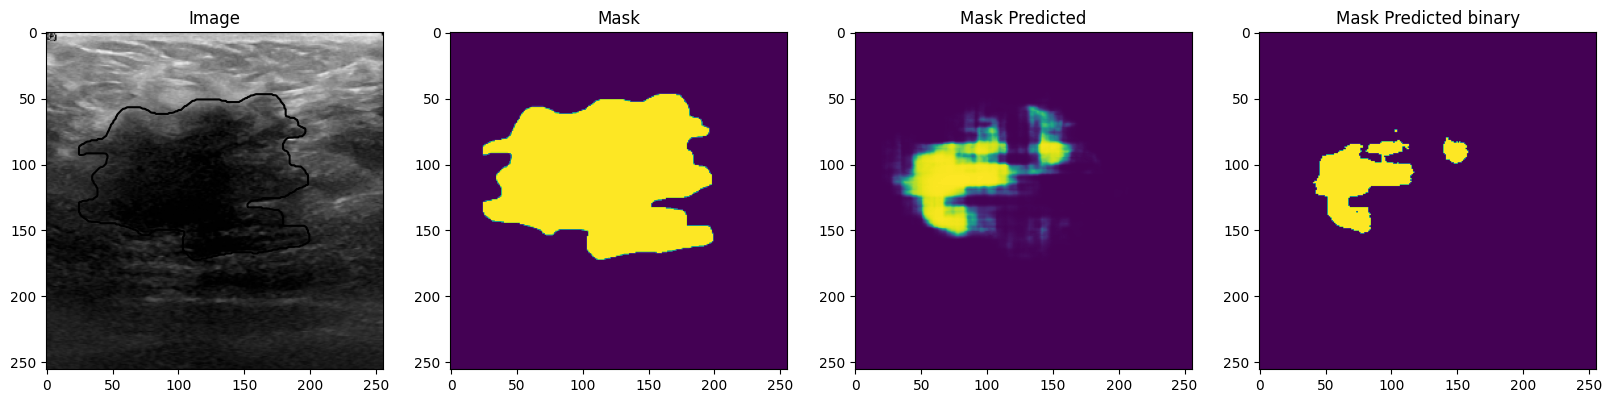

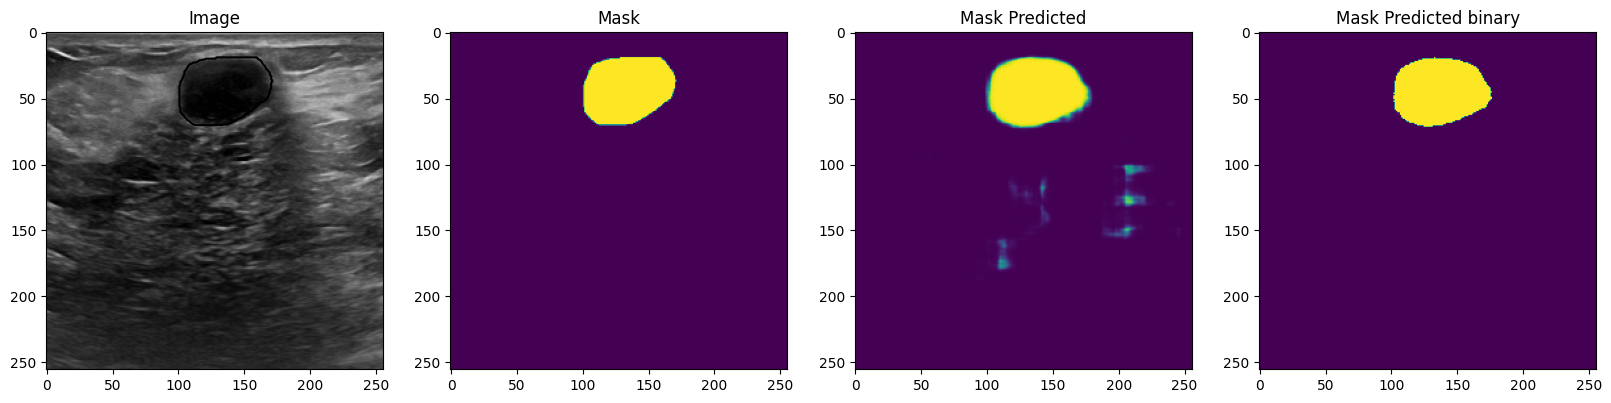

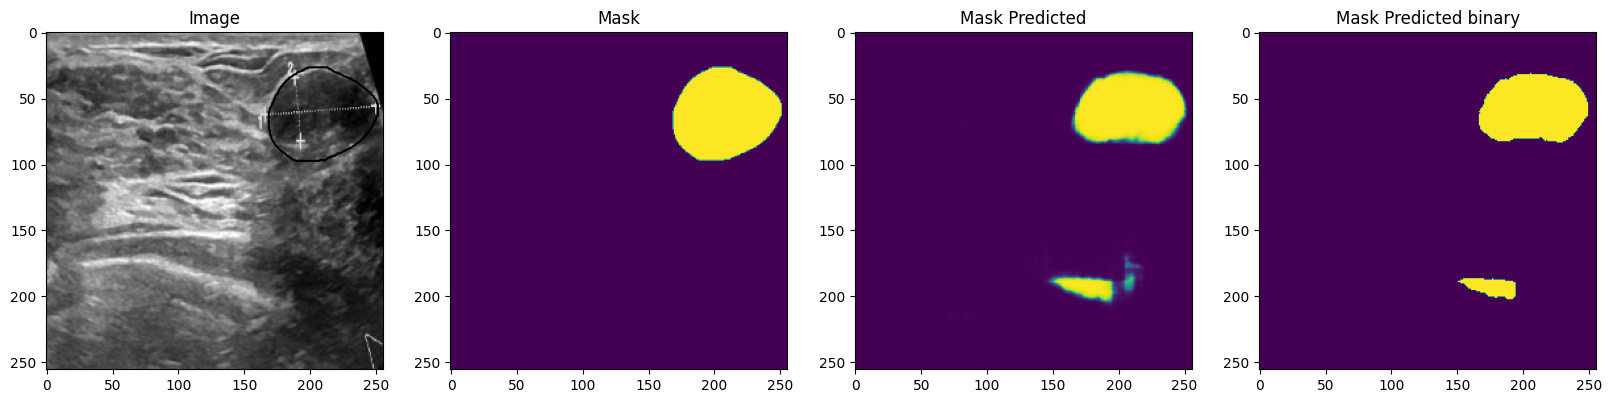

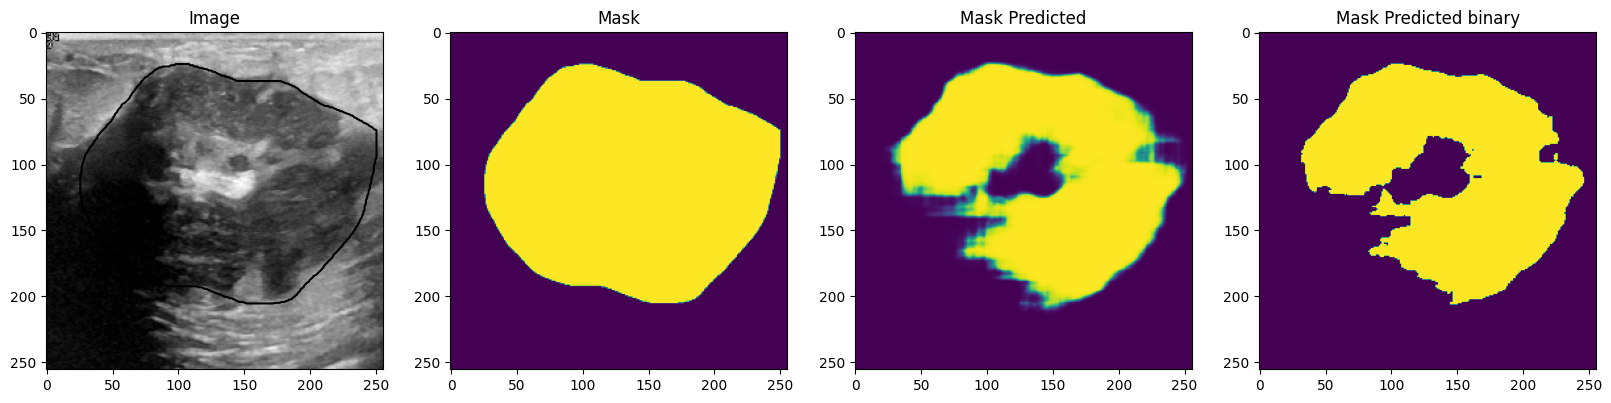

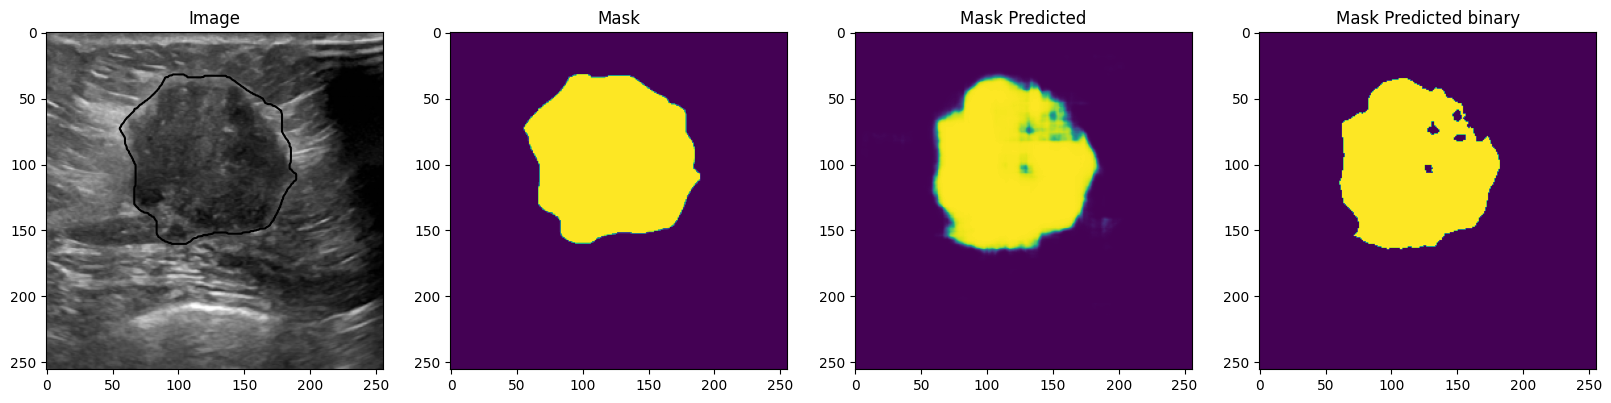

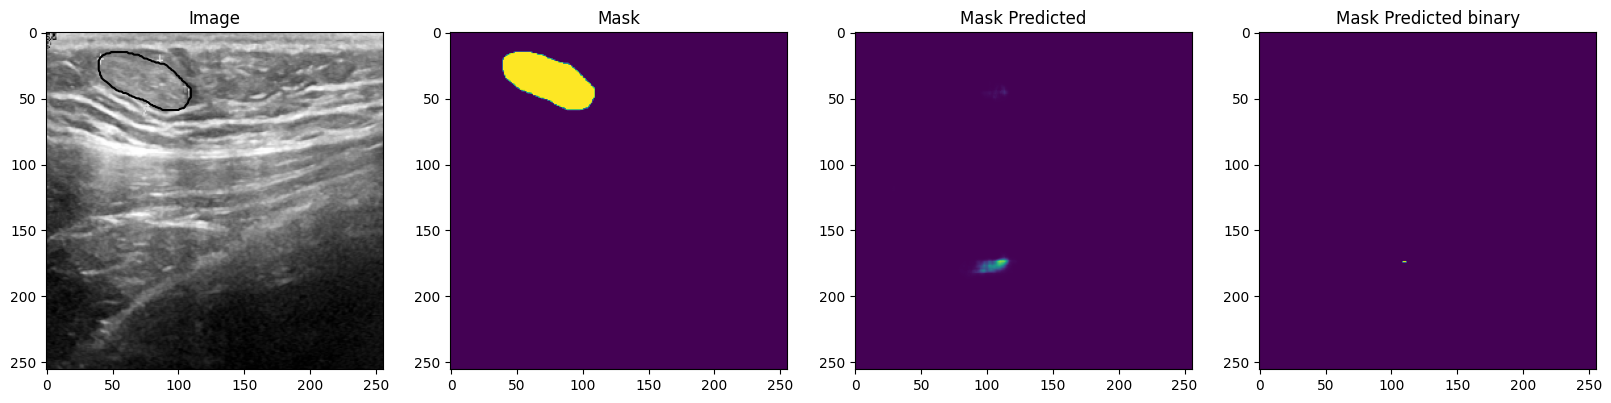

In [45]:
#@title Default title text
plot_sample(X_test, y_test, preds_test, preds_test_t)